In [20]:
import os
import re
import zipfile
import kaggle
import time
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import pydotplus
%matplotlib inline
from scipy import stats, sparse
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, KBinsDiscretizer, LabelEncoder
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold
from sklearn.metrics import make_scorer, accuracy_score, classification_report,confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost.sklearn import XGBClassifier
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Step 1 - Data Loading

In [21]:
PATH = r"C:\Users\jwang\Desktop\Kaggle\5. Airbnb-New-User-Booking"
INPUT = os.path.join(PATH, "INPUT")
OUTPUT = os.path.join(PATH, "OUTPUT") 
DATE = "(2020-5-1)"

In [22]:
def load_data(filename, path):
    filepath = os.path.join(path,filename)
    return pd.read_csv(filepath)
pd.set_option('display.max_columns', None)
df_session = load_data('sessions.csv',INPUT)
df_train = load_data('train_users_2.csv',INPUT)
df_test = load_data('test_users.csv',INPUT)
df_train_explore = df_train.copy()

# Step 2 - Data Exploration

In [23]:
df_train

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213446,zxodksqpep,2014-06-30,20140630235636,NaN,MALE,32.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NDF
213447,mhewnxesx9,2014-06-30,20140630235719,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF
213448,6o3arsjbb4,2014-06-30,20140630235754,NaN,-unknown-,32.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF
213449,jh95kwisub,2014-06-30,20140630235822,NaN,-unknown-,NaN,basic,25,en,other,other,tracked-other,iOS,iPhone,Mobile Safari,NDF


In [24]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: float64(1), int64(2), object(13)
memory usage: 26.1+ MB


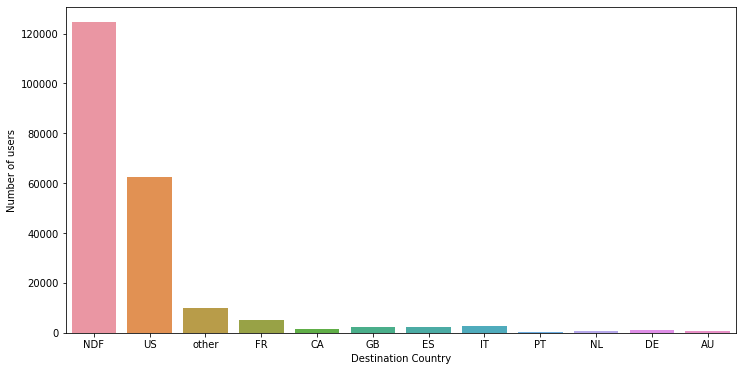

In [25]:
plt.figure(figsize=(12,6))
sns.countplot(x='country_destination', data=df_train)
plt.xlabel('Destination Country')
plt.ylabel('Number of users')
plt.show()

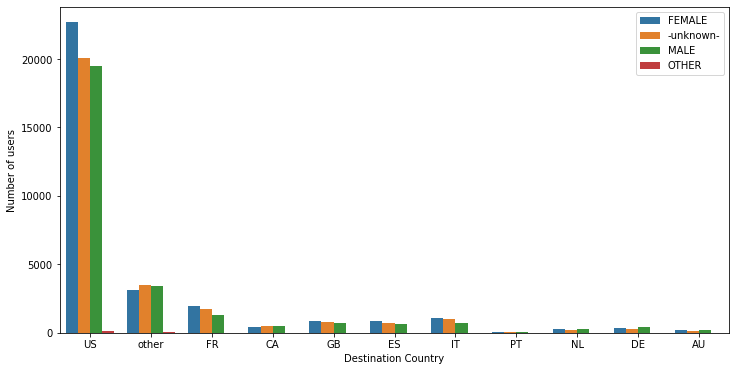

In [26]:
plt.figure(figsize=(12,6))
sns.countplot(x='country_destination', data = df_without_NDF, hue = 'gender')
plt.xlabel('Destination Country')
plt.ylabel('Number of users')
plt.legend(loc='upper right')
plt.show()

# Step 3 - Data Cleaning

In [27]:
# 1. Clean age
def age_feature_engineer(df):
    '''
    Replace outlier ages with -999 and correct age if birth year is put in.
    '''
    df = df.fillna('NA')
    df.age = df.age.replace("NA","-999").astype(int)
    df.loc[df.age>=2004,'age'] = -999
    df.loc[(df.age>100) & (df.age<200),'age'] = 100
    df.loc[(df.age>200) & (df.age<2004),'age'] = df["date_account_created"].apply(lambda x: 
                                            datetime.strptime(x, "%Y-%m-%d")).dt.year - df.age
    return df
# 2. Clean time variables
def time_var_feature_engineer(df):
    ''' 
    Create two new features - 
        1. date_diff_ac_fa (date differences between active date and account created)
        2. first_active_hour (first active hour of the day )
    '''
    df['first_active_date'] = df['timestamp_first_active'].astype(str).apply(lambda x: \
                                                                                      datetime.strptime(x[:8], "%Y%m%d"))
    df['account_created_date'] = df['date_account_created'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
    df['first_active_hour'] = df['timestamp_first_active'].astype(str).apply( \
                                    lambda x: x[8:10]).astype(int)
    df['date_diff_ac_fa'] = df['account_created_date'] - df['first_active_date']
    df['date_diff_ac_fa'] = df['date_diff_ac_fa'].dt.days
    df['first_active_year'] = df['first_active_date'].dt.year
    df['first_active_month'] = df['first_active_date'].dt.month
    df = df.drop(['timestamp_first_active', 'date_account_created', 'first_active_date', 'account_created_date'],axis=1)
    return df
# Combined
def data_preprocessing(df,train=True):
    '''
    Data preprocessing pipeline
    '''
    df_processed = df.drop(["date_first_booking"], axis=1)
    df_processed = age_feature_engineer(df_processed)
    df_processed = time_var_feature_engineer(df_processed)
    df_processed = df_processed.merge(df_session_merged,left_on='id',right_on='user_id',how='inner')
    
    if train == True:
        test_id = 0
        y_final = df_processed["country_destination"]
        df_processed = df_processed.drop(['country_destination'],axis=1)
        global onehotencode 
        onehotencode = OneHotEncoder(handle_unknown='ignore')
        df_onehot = onehotencode.fit_transform(df_processed.select_dtypes(exclude=np.number).drop('id',axis=1))
    else:
        y_final = "Hello world."
        test_id = df_processed['id']
        df_onehot = onehotencode.transform(df_processed.select_dtypes(exclude=np.number).drop('id',axis=1))
    df_onehot = pd.DataFrame.sparse.from_spmatrix(df_onehot)
    df_numeric = df_processed.select_dtypes(include=np.number)
    df_final = pd.concat([df_numeric,df_onehot],axis=1)
    
    return df_final,y_final,test_id


In [28]:
# Clean and collapse session data
df_session['count'] = 1
df_session_action_sec_sum = df_session.groupby(['user_id','action'])['secs_elapsed'].sum().unstack()
df_session_action_type_sec_sum = df_session.groupby(['user_id','action_type'])['secs_elapsed'].sum().unstack()
df_session_action_detail_sec_sum = df_session.groupby(['user_id','action_detail'])['secs_elapsed'].sum().unstack()
df_session_device_type_sec_sum = df_session.groupby(['user_id','device_type'])['secs_elapsed'].sum().unstack()
df_session_action_count_sum = df_session.groupby(['user_id','action'])['count'].sum().unstack()
df_session_action_type_count_sum = df_session.groupby(['user_id','action_type'])['count'].sum().unstack()
df_session_action_detail_count_sum = df_session.groupby(['user_id','action_detail'])['count'].sum().unstack()
df_session_device_type_count_sum = df_session.groupby(['user_id','device_type'])['count'].sum().unstack()
def rename_col(df,suffix):
    df.columns = [col + '_' + suffix for col in df.columns]
rename_col(df_session_action_sec_sum, 'action_sec')
rename_col(df_session_action_type_sec_sum, 'action_type_sec')
rename_col(df_session_action_detail_sec_sum, 'action_detail_sec')
rename_col(df_session_device_type_sec_sum, 'device_type_sec')
rename_col(df_session_action_count_sum, 'action_count')
rename_col(df_session_action_detail_count_sum, 'action_detail_count')
rename_col(df_session_device_type_count_sum, 'device_type_count')

In [29]:
# Combine features in session data 
df_session_merged = df_session_action_sec_sum.merge(df_session_action_type_sec_sum,on='user_id')
df_session_merged = df_session_merged.merge(df_session_action_detail_sec_sum,on='user_id')
df_session_merged = df_session_merged.merge(df_session_device_type_sec_sum,on='user_id')
df_session_merged = df_session_merged.merge(df_session_action_count_sum,on='user_id')
df_session_merged = df_session_merged.merge(df_session_action_type_count_sum,on='user_id')
df_session_merged = df_session_merged.merge(df_session_action_detail_count_sum,on='user_id')
df_session_merged = df_session_merged.merge(df_session_device_type_count_sum,on='user_id')

In [30]:
# Preparing features and target
X_train,y_train,drop = data_preprocessing(df_train)
le_y = LabelEncoder()
y_train_encoded = le_y.fit_transform(y_train)
X_test,y_test,test_id = data_preprocessing(df_test, train=False)

# Step 4 - Model tuning and cross-validation

In [31]:
def ndcg(pred, truth, k=5):
    '''
    NDCG evaluation metrics
    '''
    assert(len(pred)==len(truth))
    score = []
    for i in range(len(pred)):
        compare = [(x==truth[i]) for x in pred[i]]
        if 1 not in compare[:k]:
            value = 0
        else:
            value = 1 / np.log2(compare.index(1)+2)
        score.append(value)
    return np.mean(score)
def Kfold_validation(X, y, max_depth,learning_rate,n_estimators,subsample,colsample_bytree, k=5):
    '''
    Build a K-Fold cross-validation using XGBoost classifiers, with the option to tune
    depth of tree, learning rate, number of trees, and subsampling
    '''
    res = []
    train_five_fold = KFold(n_splits=k, random_state=42).split(X)
    for train_index,test_index in train_five_fold:
        X_train, y_train = X.iloc[train_index], y[train_index]
        X_test, y_test = X.iloc[test_index], y[test_index]
        xgb = XGBClassifier(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, 
                    objective='multi:softprob', subsample=subsample, colsample_bytree=colsample_bytree, seed=0)
        xgb.fit(X_train, y_train)
        prob_list = xgb.predict_proba(X_test)
        pred_list = []
        for i in range(y_test.shape[0]):
            pred_list.append(list(np.argsort(prob_list[i])[::-1][:5].tolist()))
        score = ndcg(pred_list, y_test)
        res.append(score)
    return np.mean(res) 

In [32]:
res = []
subsample = 0.75
colsample_bytree = 0.5
for max_depth in [2,3,4]:
    for learning_rate in [0.2,0.3]:
        for n_estimators in [25,50,100]:
            t0 = time.time()
            score = Kfold_validation(X_train, y_train_encoded,
                                     max_depth,learning_rate,n_estimators,
                                     subsample,colsample_bytree)
            t1 = time.time()
            running_time = t1-t0
            temp_dict = {'max_depth':max_depth, 
                         'learning_rate':learning_rate,
                         'n_estimators':n_estimators,
                         'subsample':subsample,
                         'colsample_bytree':colsample_bytree,
                         'score':score, 
                         'time':running_time}
            print(temp_dict)
            res.append(temp_dict)
df_cv_results = pd.DataFrame(res)
df_cv_results

{'max_depth': 2, 'learning_rate': 0.2, 'n_estimators': 25, 'subsample': 0.75, 'colsample_bytree': 0.5, 'score': 0.8514147081743022, 'time': 244.9180793762207}
{'max_depth': 2, 'learning_rate': 0.2, 'n_estimators': 50, 'subsample': 0.75, 'colsample_bytree': 0.5, 'score': 0.8533109663873164, 'time': 418.6253082752228}
{'max_depth': 2, 'learning_rate': 0.2, 'n_estimators': 100, 'subsample': 0.75, 'colsample_bytree': 0.5, 'score': 0.8542522792170597, 'time': 820.3156895637512}
{'max_depth': 2, 'learning_rate': 0.3, 'n_estimators': 25, 'subsample': 0.75, 'colsample_bytree': 0.5, 'score': 0.8517805562690933, 'time': 217.2974021434784}
{'max_depth': 2, 'learning_rate': 0.3, 'n_estimators': 50, 'subsample': 0.75, 'colsample_bytree': 0.5, 'score': 0.8536595575900726, 'time': 395.2783968448639}
{'max_depth': 2, 'learning_rate': 0.3, 'n_estimators': 100, 'subsample': 0.75, 'colsample_bytree': 0.5, 'score': 0.8543879826150068, 'time': 720.9072735309601}
{'max_depth': 3, 'learning_rate': 0.2, 'n_es

,max_depth,learning_rate,n_estimators,subsample,colsample_bytree,score,time
0,2,0.2,25,0.75,0.5,0.851415,244.918079
1,2,0.2,50,0.75,0.5,0.853311,418.625308
2,2,0.2,100,0.75,0.5,0.854252,820.315690
3,2,0.3,25,0.75,0.5,0.851781,217.297402
4,2,0.3,50,0.75,0.5,0.853660,395.278397
5,2,0.3,100,0.75,0.5,0.854388,720.907274
6,3,0.2,25,0.75,0.5,0.853468,390.522055
7,3,0.2,50,0.75,0.5,0.854484,666.705076
8,3,0.2,100,0.75,0.5,0.854643,1308.328116
9,3,0.3,25,0.75,0.5,0.853603,373.342352


In [35]:
# Pick the best parameters and train the model
t0 = time.time()
xgb = XGBClassifier(max_depth=3, learning_rate=0.2, n_estimators=100, 
                    objective='multi:softprob', subsample=0.75, colsample_bytree=0.5, seed=0)
xgb.fit(X_train, y_train_encoded)
t1 = time.time()
print("Time to train the final model --- {} seconds".format(int(t1-t0)))

Time to train the final model --- 386 seconds


In [36]:
# Create result list based on the model prediction
res = xgb.predict_proba(X_test)
id_list = []
country_list = []
for i in range(len(test_id)):
    id_list += [test_id[i]] * 5
    country_list += le_y.inverse_transform(np.argsort(res[i])[::-1])[:5].tolist()

In [37]:
final = pd.DataFrame(list(zip(id_list,country_list)), 
                     columns=['id','country'])
final.to_csv(os.path.join(OUTPUT, 'Final result.csv'),index=False)